In [1]:
# Dataset path
from os import listdir
import os.path

PATH = './faces_dataset_train/'
PATH_TEST = './faces_dataset_test/'

assert os.path.exists(PATH), 'Verify the above commands'
assert os.path.exists(PATH_TEST), 'Verify the above commands'

### Metadata access

In [2]:
import json

with open(PATH + 'metadata.json') as fIn:
    metadata = json.loads(fIn.read())
with open(PATH_TEST + 'metadata.json') as fIn:
    metadata_test = json.loads(fIn.read())

metadata_example_key = next(iter(metadata.keys()))
metadata_example_value = metadata[metadata_example_key]

print(metadata_example_key, end=' ----> ')
print(metadata_example_value)

i07/nm0322407_rm852269056_1955-3-29_2005.jpg ----> {'age': 50, 'gender': 'M'}


### Image reading

In [3]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Tensor("StringSplit/RaggedGetItem/strided_slice_5:0", shape=(None,), dtype=string)
Image shape:  (32, 32, 3)
Label:  0


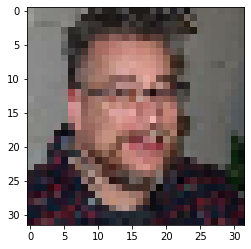

Image shape:  (32, 32, 3)
Label:  0


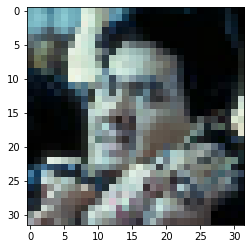

Image shape:  (32, 32, 3)
Label:  1


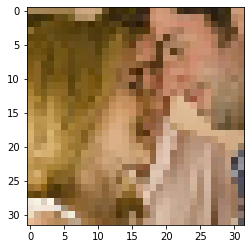

Image shape:  (32, 32, 3)
Label:  0


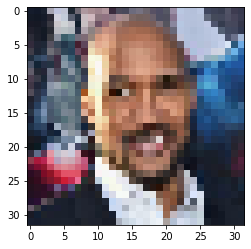

Image shape:  (32, 32, 3)
Label:  0


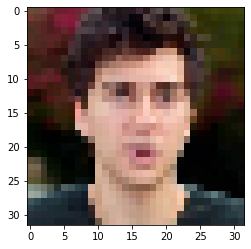

In [4]:
import tensorflow as tf
from matplotlib import pyplot

# Size at which images will be processed
img_height = 32
img_width = 32

def decode_img(img):
    '''Transforms a string that represents the path of an image into a matrix
    (img_height, img_width, 3) of uint8 representing the pixel values
    '''
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size.
    return tf.cast(tf.image.resize(img, [img_height, img_width]),tf.uint8)

# def process_path_age(file_path):
#     '''Transforma cadenas de la forma 'ruta|edad|genero' a tuplas (imagen, etiqueta)
#     '''
#     parts = tf.strings.split(file_path, '|')
#     age = parts[1]
#     age = tf.strings.to_number(age, out_type=tf.dtypes.int32)
#     gender = parts[2]
#     # Load the raw data from the file as a string
#     img = tf.io.read_file(parts[0])
#     img = decode_img(img)
#     return img, age

def process_path(file_path):
    '''Transforms strings of the form 'path|age|gender' to tuples (image, label)
    '''
    parts = tf.strings.split(file_path, '|')
    print(parts)
    gender = tf.cast(0 if parts[2] == 'M' else 1, tf.dtypes.int32)
    # Load the raw data from the file as a string
    img = tf.io.read_file(parts[0])
    img = decode_img(img)
    return img, gender

def format_metadata(m, path):
    '''Transforms the metadata dictionary m into a list of strings of the form 'path to the image|age|gender'.
    '''
    return list(map(lambda x: '{0}{1}|{2}|{3}'.format(path,x,m[x]['age'],m[x]['gender']),m.keys()))

# We build a dataset of text strings from the metadata
train_metadata = format_metadata(metadata, PATH)
train_ds = tf.data.Dataset.from_tensor_slices(train_metadata)
print(train_ds.take(1))

# Mapping to an image dataset with tags
train_ds = train_ds.shuffle(len(train_ds)).map(process_path)

# Same process for test
test_ds = tf.data.Dataset.from_tensor_slices(format_metadata(metadata_test, PATH_TEST))
test_ds = test_ds.map(process_path)

# Checking
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    pyplot.imshow(image.numpy())
    pyplot.show()

In [5]:
ds_train_transform = train_ds
ds_test_transform = test_ds
print(train_metadata[0])

./faces_dataset_train/i07/nm0322407_rm852269056_1955-3-29_2005.jpg|50|M


In [6]:
# OPTIONAL: rescaling input to [-1, 1]
ds_train_transform = ds_train_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))
ds_test_transform = ds_test_transform.map(lambda image, label: (tf.cast(image, tf.float32)/127.5 - 1., label))

In [7]:
# OPTIONAL: sample gender weights
import numpy as np
labels = [0 if x.split('|')[2] == 'M' else 1 for x in train_metadata]
freqs = np.array([1. - np.mean(labels), np.mean(labels)])
i_freqs = 1. / freqs
sample_weights = tf.convert_to_tensor(len(i_freqs) * i_freqs / i_freqs.sum())
print(sample_weights)
ds_train_transform = ds_train_transform.map(lambda image, label: (image, label, sample_weights[label]))
ds_test_transform = ds_test_transform.map(lambda image, label: (image, label, sample_weights[label]))

tf.Tensor([0.8294171 1.1705829], shape=(2,), dtype=float64)


In [8]:
batch_size = 128
ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

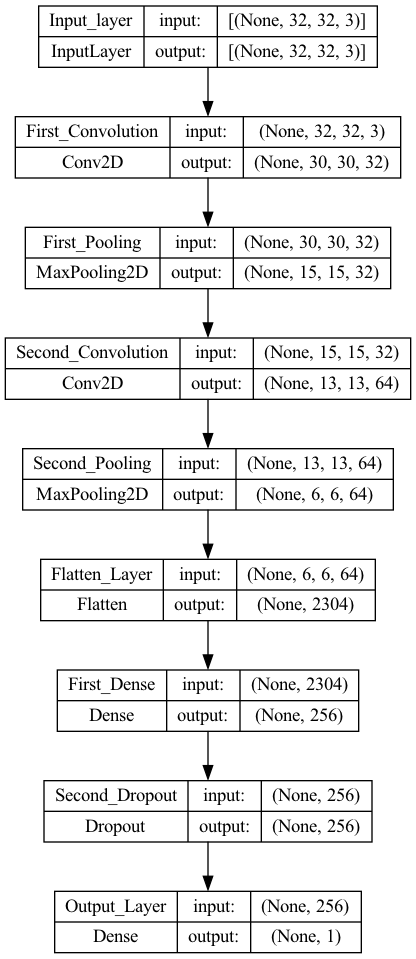

In [23]:
from keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import Input, Model
from keras.utils import plot_model

input_shape = (32, 32, 3)

input = Input(shape=input_shape,name = 'Input_layer')

conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name = 'First_Convolution')(input)
pooling1 = MaxPooling2D(pool_size=(2, 2), name = 'First_Pooling')(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', name = 'Second_Convolution')(pooling1)
pooling2 = MaxPooling2D(pool_size=(2, 2), name = 'Second_Pooling')(conv2)
flat = Flatten(name = 'Flatten_Layer')(pooling2)
dense1 = Dense(256, activation='relu', name = 'First_Dense')(flat)
drop1 = Dropout(0.5, name = 'First_Dropout')(dense1)
dense2 = Dense(128, activation='relu', name = 'Second_Dense')(drop1)
drop2 = Dropout(0.5, name = 'Second_Dropout')(dense1)
output = Dense(1, activation='sigmoid', name = 'Output_Layer')(drop2)

model = Model(inputs=input,outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],weighted_metrics=[])
plot_model(model,show_shapes=True)

In [24]:
dataset_size = ds_train_transform.reduce(0, lambda x, _: x + 1).numpy()
dataset_size

126865

Epoch 1/20
248/248 [==============================] - ETA: 0s - loss: 0.4197 - accuracy: 0.8058
Epoch 1: val_loss improved from inf to 0.34938, saving model to best_weights.h5
248/248 [==============================] - 17s 56ms/step - loss: 0.4197 - accuracy: 0.8058 - val_loss: 0.3494 - val_accuracy: 0.8800
Epoch 2/20
247/248 [============================>.] - ETA: 0s - loss: 0.3312 - accuracy: 0.8646
Epoch 2: val_loss improved from 0.34938 to 0.33416, saving model to best_weights.h5
248/248 [==============================] - 13s 53ms/step - loss: 0.3312 - accuracy: 0.8646 - val_loss: 0.3342 - val_accuracy: 0.8800
Epoch 3/20
247/248 [============================>.] - ETA: 0s - loss: 0.3124 - accuracy: 0.8751
Epoch 3: val_loss did not improve from 0.33416
248/248 [==============================] - 14s 55ms/step - loss: 0.3126 - accuracy: 0.8750 - val_loss: 0.3367 - val_accuracy: 0.8700
Epoch 4/20
247/248 [============================>.] - ETA: 0s - loss: 0.3013 - accuracy: 0.8807
Epoch 

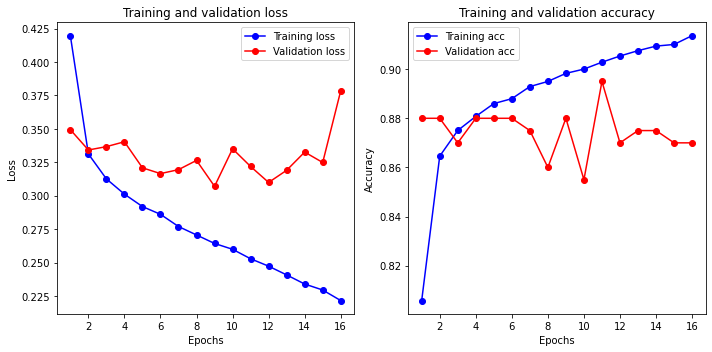

In [26]:
num_epochs = 20
batch_size = 512
patience = 7

ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=1)
checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
history = model.fit(ds_train_batch, epochs=num_epochs,callbacks=[early_stopping, checkpoint],validation_data=ds_test_batch)

visualize_fit(history)


Epoch 1: val_loss improved from inf to 0.40913, saving model to best_weights.h5

Epoch 2: val_loss improved from 0.40913 to 0.37232, saving model to best_weights.h5

Epoch 3: val_loss improved from 0.37232 to 0.37065, saving model to best_weights.h5

Epoch 4: val_loss did not improve from 0.37065

Epoch 5: val_loss improved from 0.37065 to 0.36141, saving model to best_weights.h5

Epoch 6: val_loss improved from 0.36141 to 0.34461, saving model to best_weights.h5

Epoch 7: val_loss did not improve from 0.34461

Epoch 8: val_loss did not improve from 0.34461

Epoch 9: val_loss did not improve from 0.34461

Epoch 10: val_loss did not improve from 0.34461

Epoch 11: val_loss did not improve from 0.34461

Epoch 12: val_loss improved from 0.34461 to 0.34230, saving model to best_weights.h5

Epoch 13: val_loss did not improve from 0.34230

Epoch 14: val_loss did not improve from 0.34230

Epoch 15: val_loss improved from 0.34230 to 0.34094, saving model to best_weights.h5

Epoch 16: val_loss

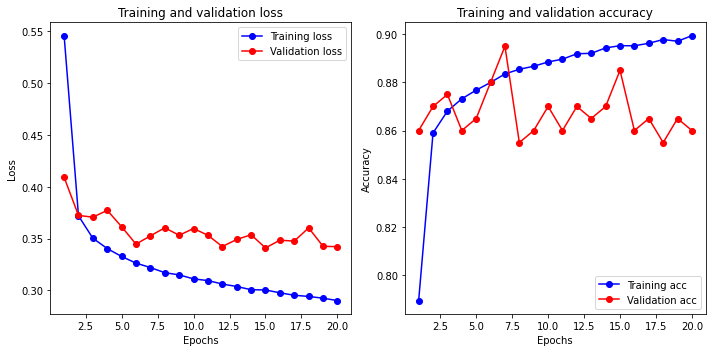

In [28]:
from keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import Input, Model
from keras.utils import plot_model

from tensorflow.keras import regularizers

regularizer = regularizers.l2(0.001)

input_shape = (32, 32, 3)

input = Input(shape=input_shape,name = 'Input_layer')

conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name = 'First_Convolution')(input)
pooling1 = MaxPooling2D(pool_size=(2, 2), name = 'First_Pooling')(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', name = 'Second_Convolution')(pooling1)
pooling2 = MaxPooling2D(pool_size=(2, 2), name = 'Second_Pooling')(conv2)
flat = Flatten(name = 'Flatten_Layer')(pooling2)
dense1 = Dense(256, activation='relu', kernel_regularizer=regularizer, name = 'First_Dense')(flat)
drop1 = Dropout(0.5, name = 'First_Dropout')(dense1)
dense2 = Dense(128, activation='relu', kernel_regularizer=regularizer, name = 'Second_Dense')(drop1)
drop2 = Dropout(0.5, name = 'Second_Dropout')(dense1)
output = Dense(1, activation='sigmoid', name = 'Output_Layer')(drop2)

model = Model(inputs=input,outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],weighted_metrics=[])

num_epochs = 20
batch_size = 512
patience = 7


ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=1)
checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
history = model.fit(ds_train_batch, verbose = 0, epochs=num_epochs,callbacks=[early_stopping, checkpoint],validation_data=ds_test_batch)

visualize_fit(history)


Epoch 1: val_loss improved from inf to 0.39554, saving model to best_weights.h5

Epoch 2: val_loss improved from 0.39554 to 0.38292, saving model to best_weights.h5

Epoch 3: val_loss improved from 0.38292 to 0.36626, saving model to best_weights.h5

Epoch 4: val_loss improved from 0.36626 to 0.36190, saving model to best_weights.h5

Epoch 5: val_loss did not improve from 0.36190

Epoch 6: val_loss improved from 0.36190 to 0.35917, saving model to best_weights.h5

Epoch 7: val_loss did not improve from 0.35917

Epoch 8: val_loss did not improve from 0.35917

Epoch 9: val_loss improved from 0.35917 to 0.35410, saving model to best_weights.h5

Epoch 10: val_loss did not improve from 0.35410

Epoch 11: val_loss improved from 0.35410 to 0.35312, saving model to best_weights.h5

Epoch 12: val_loss did not improve from 0.35312

Epoch 13: val_loss improved from 0.35312 to 0.35116, saving model to best_weights.h5

Epoch 14: val_loss did not improve from 0.35116

Epoch 15: val_loss did not imp

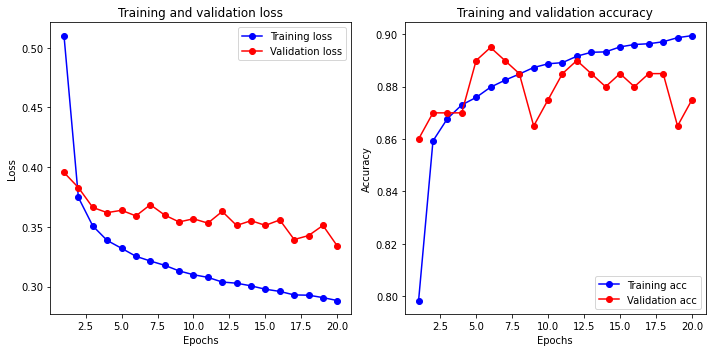

In [30]:
from keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import Input, Model
from keras.utils import plot_model

from tensorflow.keras import regularizers

regularizer = regularizers.l2(0.001)

input_shape = (32, 32, 3)

input = Input(shape=input_shape,name = 'Input_layer')

conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name = 'First_Convolution')(input)
pooling1 = MaxPooling2D(pool_size=(2, 2), name = 'First_Pooling')(conv1)
conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu', name = 'Second_Convolution')(pooling1)
pooling2 = MaxPooling2D(pool_size=(2, 2), name = 'Second_Pooling')(conv2)
conv3 = Conv2D(64, kernel_size=(3, 3), activation='relu', name = 'Third_Convolution')(pooling1)
pooling3 = MaxPooling2D(pool_size=(2, 2), name = 'Third_Pooling')(conv3)
flat = Flatten(name = 'Flatten_Layer')(pooling3)
dense1 = Dense(128, activation='relu', kernel_regularizer=regularizer, name = 'First_Dense')(flat)
drop1 = Dropout(0.5, name = 'First_Dropout')(dense1)
output = Dense(1, activation='sigmoid', name = 'Output_Layer')(drop1)

model = Model(inputs=input,outputs=output)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],weighted_metrics=[])
plot_model(model,show_shapes=True)

num_epochs = 20
batch_size = 512
patience = 7


ds_train_batch = ds_train_transform.batch(batch_size)
ds_test_batch = ds_test_transform.batch(batch_size)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=1)
checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
history = model.fit(ds_train_batch, verbose = 0, epochs=num_epochs,callbacks=[early_stopping, checkpoint],validation_data=ds_test_batch)

visualize_fit(history)

Epoch 1/20
248/248 [==============================] - ETA: 0s - loss: 0.2787 - accuracy: 0.8906
Epoch 1: val_loss improved from inf to 0.34908, saving model to best_weights.h5
248/248 [==============================] - 13s 51ms/step - loss: 0.2787 - accuracy: 0.8906 - val_loss: 0.3491 - val_accuracy: 0.8500
Epoch 2/20
248/248 [==============================] - ETA: 0s - loss: 0.2746 - accuracy: 0.8927
Epoch 2: val_loss improved from 0.34908 to 0.34764, saving model to best_weights.h5
248/248 [==============================] - 13s 51ms/step - loss: 0.2746 - accuracy: 0.8927 - val_loss: 0.3476 - val_accuracy: 0.8550
Epoch 3/20
248/248 [==============================] - ETA: 0s - loss: 0.2696 - accuracy: 0.8944
Epoch 3: val_loss did not improve from 0.34764
248/248 [==============================] - 13s 52ms/step - loss: 0.2696 - accuracy: 0.8944 - val_loss: 0.3530 - val_accuracy: 0.8450
Epoch 4/20
248/248 [==============================] - ETA: 0s - loss: 0.2664 - accuracy: 0.8954
Epoch 

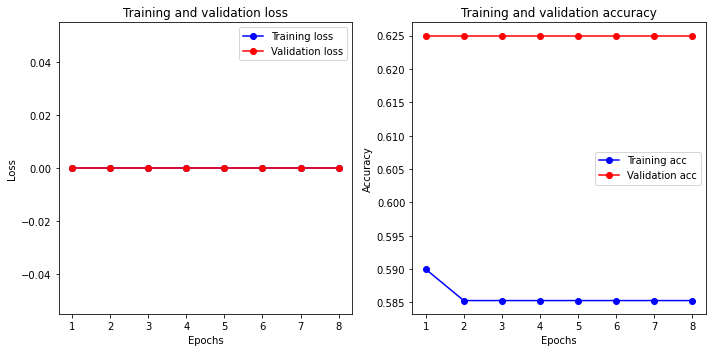

In [26]:
num_epochs = 20
batch_size = 512
patience = 7

ds_train_batch = ds_train_transform.batch(batch_size)

# ds_train_shuffle = ds_train_transform.shuffle(10000)
# ds_train_batch = ds_train_shuffle.skip(int(dataset_size * 0.2)).batch(batch_size)
# ds_val_batch = ds_train_shuffle.take(int(dataset_size * 0.2)).batch(batch_size)

ds_test_batch = ds_test_transform.batch(batch_size)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=patience, mode='min', verbose=1)
checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
model.fit(ds_train_batch, verbose = 1, epochs=num_epochs,callbacks=[early_stopping, checkpoint],validation_data=ds_test_batch)

new_model = Model(inputs=input,outputs=output)

new_model.load_weights('best_weights.h5')

# Compilar el nuevo modelo con los mismos hiperparámetros que el modelo anterior
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = new_model.fit(ds_train_batch, verbose = 1, epochs=num_epochs,callbacks=[early_stopping, checkpoint],validation_data=ds_test_batch)

visualize_fit(history)

In [14]:
model.evaluate(ds_test_batch)

992/992 [==============================] - 13s 13ms/step - loss: 0.2664 - accuracy: 0.8984


[0.2664489150047302, 0.898411750793457]

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_fit(history):
    history_dict = history.history
    history_dict.keys()

    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, 'b-o', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r-o', label='Validation loss')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']

    plt.plot(epochs, acc, 'b-o', label='Training acc')
    plt.plot(epochs, val_acc, 'r-o', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()